# Reparameterization of the Birkhoff Polytope

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# First consider sampling a random permutation matrix
def sample_permutation(N, p, verbose=False):
    """
    Raster scan and sample
    """
    P = np.zeros((N,N), dtype=int)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Sample
            if lb == 0 and ub == 1:
                P[i,j] = np.random.rand() < p
            else:
                assert lb == ub
                P[i,j] = lb
        
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

def check_permutation(P):
    assert np.allclose(P.sum(0), 1)
    assert np.allclose(P.sum(1), 1)
    assert np.min(P) == 0
    assert np.max(P) == 1
    

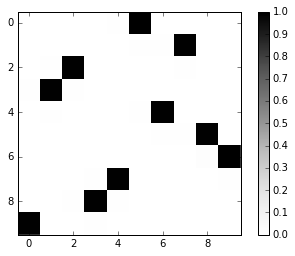

In [3]:
N = 10
for _ in range(100): 
    P = sample_permutation(N, 2./N)
    check_permutation(P)


plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [4]:
# First consider sampling a random doubly stochastic matrix
def logistic(psi):
    return 1./(1+np.exp(-psi))

def sample_doubly_stochastic(Psi, verbose=False):
    """
    Same as above but with a sample on the interval (lb, ub)
    """
    N = Psi.shape[0] + 1
    assert Psi.shape == (N-1,N-1)
    
    P = np.zeros((N,N), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Sample
            P[i,j] = lb + (ub - lb) * logistic(Psi[i,j])
            
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

def check_doubly_stochastic(P):
    assert np.allclose(P.sum(0), 1)
    assert np.allclose(P.sum(1), 1)
    assert np.min(P) >= 0
    assert np.max(P) <= 1


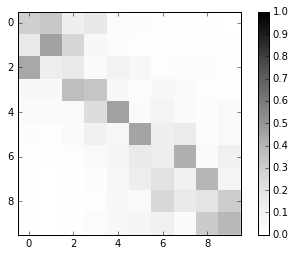

In [6]:
N = 10
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

P = sample_doubly_stochastic(Psi)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [7]:

def sample_doubly_stochastic_stable(Psi, epsilon=1e-4, verbose=False):
    """
    Same as above but now we require that each stick is at least epsilon.
    This ensures that there is always some dynamic range for inverting
    Pi to Psi. 
    """
    N = Psi.shape[0] + 1
    assert Psi.shape == (N-1,N-1)
    
    P = np.zeros((N,N), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - (N-(j+1)) * epsilon - np.sum(P[i,:j])
            
            # Upper bounded by partial column sum
            ub_col = 1 - (N-(i+1)) * epsilon - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
#             lb_rem = (1 - np.sum(P[i,:j])) - \
#                      (N - (j + 1)) + \
#                      (N - (j + 1)) * (N - (i + 1)) * epsilon + \
#                      np.sum(P[:i,j+1:])
            
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2:.3f} lb: {3:.3f}  ub: {4:.3f}".format(i,j,lb_rem,lb,ub))
            
            assert ub >= lb
            assert ub <= 1
            assert ub > 0
            
            # Sample
            P[i,j] = lb + (ub - lb) * logistic(Psi[i,j])
            
        # Finish off the row
        P[i,-1] = 1-np.sum(P[i,:-1])
        
    # Finish off the columns
    for j in range(N):
        P[-1,j] = 1-np.sum(P[:-1,j])
    
    return P

In [8]:
N = 3
Psi = -np.inf * np.ones((N-1,N-1))

P = sample_doubly_stochastic_stable(Psi, epsilon=0, verbose=True)
print(P.min())
print(P.max())
check_doubly_stochastic(P)


(0, 0): lb_rem: -1.000 lb: 0.000  ub: 1.000
(0, 1): lb_rem: 0.000 lb: 0.000  ub: 1.000
(1, 0): lb_rem: 0.000 lb: 0.000  ub: 1.000
(1, 1): lb_rem: 1.000 lb: 1.000  ub: 1.000
0.0
1.0


3.68619611214e-08
0.653023670298


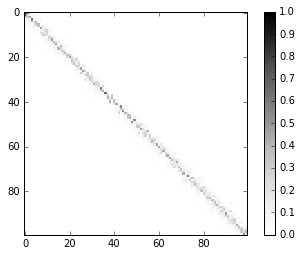

In [9]:
N = 100
tau = 1.0
Psi = tau * np.random.randn(N-1, N-1)

P = sample_doubly_stochastic_stable(Psi, epsilon=1e-6, verbose=False)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

print(P.min())
print(P.max())

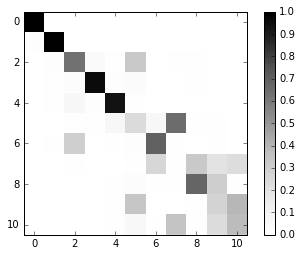

In [10]:
N = 10
tau = 10.0
Psi = tau * np.random.randn(N, N)

P = sample_doubly_stochastic_stable(Psi)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.colorbar()

In [11]:
# Check the density calculations
def logit(pi):
    return np.log(pi/(1-pi))

def invert_Pi(P, epsilon=1e-4, verbose=False):
    """
    Invert Pi to get Psi. Note that this is pretty unstable for large N and tau.
    """
    N = P.shape[0]
    assert P.shape == (N,N)
    
    Psi = np.zeros((N-1,N-1), dtype=float)
    for i in range(N-1):
        for j in range(N-1):
            # Upper bounded by partial row sum
            ub_row = 1 - (N-(j+1)) * epsilon - np.sum(P[i,:j])
            # Upper bounded by partial column sum
            ub_col = 1 - (N-(i+1)) * epsilon - np.sum(P[:i,j])
            
            # Lower bounded (see notes)
            lb_rem = (1 - np.sum(P[i,:j])) - (N - (j + 1)) + np.sum(P[:i,j+1:])
#             lb_rem = (1 - np.sum(P[i,:j])) - \
#                      (N - (j + 1)) + \
#                      (N - (j + 1)) * (N - (i + 1)) * epsilon + \
#                      np.sum(P[:i,j+1:])
                
            # Combine constraints
            ub = min(ub_row, ub_col)
            lb = max(0, lb_rem)
            
            if verbose:
                print("({0}, {1}): lb_rem: {2} lb: {3}  ub: {4}".format(i,j,lb_rem,lb,ub))
            
            # Sample
            Psi[i,j] = logit((P[i,j] - lb) / (ub - lb))
            assert np.isfinite(Psi[i,j])
        
    return Psi

3.57047724719e-13


(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

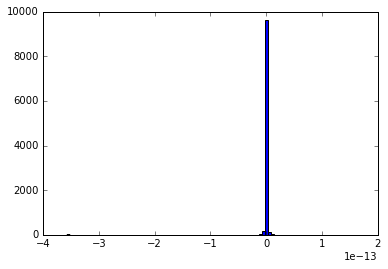

In [12]:
N = 100
tau = 2.0
Psi = tau * np.random.randn(N, N)

P = sample_doubly_stochastic_stable(Psi)
Psi2 = invert_Pi(P)
print(abs(Psi-Psi2).max())
# assert np.allclose(Psi, Psi2)
plt.hist(Psi.ravel() - Psi2.ravel(), 100)

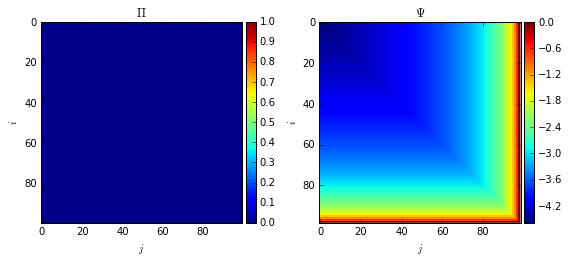

In [20]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

Pi = 1./N *np.ones((N,N))
Psi = invert_Pi(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
plt.savefig("uniform_pi_psi.png")

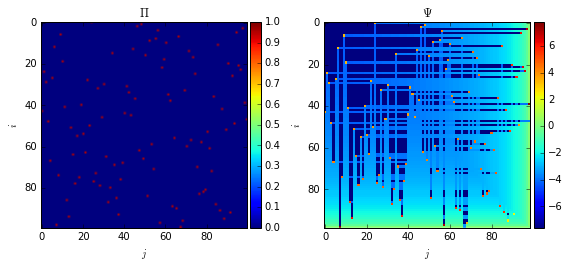

In [113]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

P2 = 1./N * np.ones((N,N))

alpha = 0.95
Pi = alpha * P1 + (1-alpha) * P2 
check_doubly_stochastic(Pi)

Psi = invert_Pi(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
plt.savefig("random_pi_psi.png")

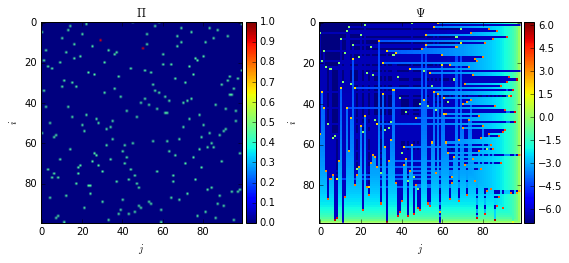

In [114]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 100

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

p2 = np.random.permutation(N)
P2 = np.zeros((N,N))
P2[np.arange(N), p2] = 1

P3 = 1./N * np.ones((N,N))

alpha = [0.45, 0.45]
Pi = alpha[0] * P1 + alpha[1] * P2 + (1-alpha[0]-alpha[1]) * P3
check_doubly_stochastic(Pi)

Psi = invert_Pi(Pi)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(Psi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()
plt.savefig("twoperm_pi_psi.png")

In [115]:
np.set_printoptions(precision=3)
Pi[0]

array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.451,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.451,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001])

8.30164949515e-05
0.29079740718


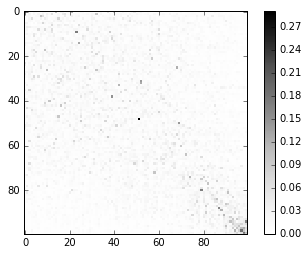

In [123]:
# Sample from distribution with uniform mean
Pi = 1./N * np.ones((N,N))
check_doubly_stochastic(Pi)

# Use this as the mean
mu = invert_Pi(Pi)
tau = 1.0
# Psi = mu + 1./tau * np.random.randn(N-1, N-1)
Psi = (mu + np.random.randn(N-1, N-1)) / tau

P = sample_doubly_stochastic_stable(Psi, verbose=False)
check_doubly_stochastic(P)

plt.imshow(P, vmin=0,  interpolation="none", cmap="Greys")
plt.colorbar()

print(P.min())
print(P.max())

In [121]:
# Sample from distribution with given permutation as mean
p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1
P2 = 1./N * np.ones((N,N))
alpha = 0.95
Pi = alpha * P1 + (1-alpha) * P2 
check_doubly_stochastic(Pi)

# Use this as the mean
mu = invert_Pi(Pi)
tau = 0.1
# Psi = mu + 1./tau * np.random.randn(N-1, N-1)
Psi = (mu + np.random.randn(N-1, N-1)) / tau

P = sample_doubly_stochastic_stable(Psi, verbose=False)
check_doubly_stochastic(P)


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
im1 = plt.imshow(Pi, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Mean $\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax1 = fig.add_subplot(132)
im1 = plt.imshow(P, vmin=0, vmax=1)
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Sampled $\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = fig.add_subplot(133)
im2 = ax2.imshow(P-Pi, interpolation="none")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("Sampled minus mean")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

plt.tight_layout()

AssertionError: 

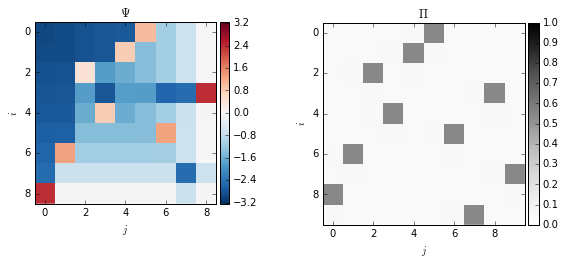

In [29]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 10

p1 = np.random.permutation(N)
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

p2 = np.random.permutation(N)
P2 = np.zeros((N,N))
P2[np.arange(N), p2] = 1

P3 = 1./N * np.ones((N,N))

alpha = [0.5, 0.]
Pi = alpha[0] * P1 + alpha[1] * P2 + (1-alpha[0]-alpha[1]) * P3
check_doubly_stochastic(Pi)

Psi = invert_Pi(Pi)
Psi_lim = abs(Psi).max()

# Psi_pad = -np.inf * np.ones((N,N))
# Psi_pad[:-1,:-1] = Psi


from mpl_toolkits.axes_grid1 import make_axes_locatable
from hips.plotting.layout import create_axis_at_location

fig = plt.figure(figsize=(8,4))

ax2 = create_axis_at_location(fig, 0.5, 0.5 + (1./N) * 3., float(N-1)/N *3, float(N-1)/N * 3)
# ax2 = fig.add_subplot(121)
im2 = ax2.imshow(Psi, vmin=-1.1*Psi_lim, vmax=1.1*Psi_lim, interpolation="none", cmap="RdBu_r")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Psi$")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

# ax1 = fig.add_subplot(122)
ax1 = create_axis_at_location(fig, 4.5, 0.5, 3, 3)
im1 = plt.imshow(Pi, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.title("$\Pi$")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

# plt.tight_layout()
plt.savefig("pi_psi_10.png")

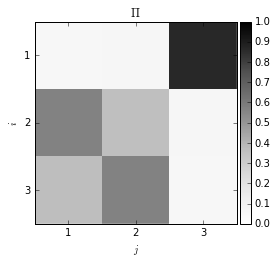

In [40]:
# What does the inverse of the "uniform" doubly stochastic matrix look like?
N = 3

# p1 = np.random.permutation(N)
p1 = np.array([2,1,0])
P1 = np.zeros((N,N))
P1[np.arange(N), p1] = 1

p2 = np.array([2,0,1])
P2 = np.zeros((N,N))
P2[np.arange(N), p2] = 1

P3 = 1./N * np.ones((N,N))

alpha = [0.3, 0.5]
Pi = alpha[0] * P1 + alpha[1] * P2 + (1-alpha[0]-alpha[1]) * P3
check_doubly_stochastic(Pi)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from hips.plotting.layout import create_axis_at_location

fig = plt.figure(figsize=(4,4))

# ax1 = fig.add_subplot(122)
ax1 = create_axis_at_location(fig, .5, 0.5, 3, 3)
im1 = plt.imshow(Pi, vmin=0, vmax=1, interpolation="none", cmap="Greys")
plt.xlabel("$j$")
plt.ylabel("$i$")
plt.xticks(np.arange(N), 1+np.arange(N))
plt.yticks(np.arange(N), 1+np.arange(N))
plt.title("$\Pi$")


divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

plt.savefig("pi_3b.png")